# Author

Ronen H

# Load Libraries

In [1]:
import os
import gzip
from tqdm import tqdm
import orjson
from collections import Counter
import html
import pandas as pd
import numpy as np
import networkx as nx
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Prepare Video Games Data

## Obtain Common Video Game Categories

In [2]:
unique_games = set() # Seen games.
game_titles = {} # Titles of video games.
game_category_counts = Counter() # Video game category counts.
with gzip.open('meta_Video_Games.json.gz') as games_file:
    for json_line in tqdm(games_file):
        game = orjson.loads(json_line)
        game_id = game['asin']
        if game_id not in unique_games: # Not duplicate game.
            unique_games.add(game_id)
            game_titles[game_id] = html.unescape(game['title']).strip()
            categories = set()
            for category in game['category']:
                category = html.unescape(category).strip()
                if category == '</span></span></span>': # Anything after most insignificant.
                    break
                if category != 'Video Games': # Every video game has category 'Video Games'.
                    categories.add(category)
            game_category_counts.update(Counter(categories))
del unique_games

game_categories = {} # Common categories of video games.
with gzip.open('meta_Video_Games.json.gz') as games_file:
    for json_line in tqdm(games_file):
        game = orjson.loads(json_line)
        game_id = game['asin']
        if game_id not in game_categories: # Not duplicate game.
            game_categories[game_id] = set()
            for category in game['category']:
                category = html.unescape(category).strip()
                # Common if appears at least in 10 video games.
                if category != 'Video Games' and category != '</span></span></span>' and game_category_counts[category] >= 10:
                    game_categories[game_id].add(category)
del game_category_counts

0it [00:00, ?it/s]

84819it [00:04, 18029.94it/s]
84819it [00:03, 22681.99it/s]


## Obtain Video Game Information

In [3]:
unique_reviews = set() # Seen reviews.
games = {} # Information about video games.
with gzip.open('Video_Games.json.gz') as reviews_file:
    for json_line in tqdm(reviews_file):
        review = orjson.loads(json_line)
        user = review['reviewerID']
        game = review['asin']
        rating = review['overall']
        vote = 0
        if 'vote' in review:
            vote = int(review['vote'].replace(',', ''))
        verified = review['verified']
        if (user, game, rating, vote, verified) not in unique_reviews: # Not duplicate review.
            unique_reviews.add((user, game, rating, vote, verified))
            if game not in games:
                games[game] = {'user': [], 'rating': [], 'vote': [], 'verified': []}
            games[game]['user'].append(user)
            games[game]['rating'].append(rating)
            games[game]['vote'].append(vote)
            games[game]['verified'].append(verified)
del unique_reviews

games_info = {'game': [], 'title': [], 'user': [], 'rating': [], 'vote': [], 'verified': [], 'category': []}
for game, game_info in games.items():
    games_info['game'].append(game)
    if game in game_titles:
        games_info['title'].append(game_titles[game])
    else:
        games_info['title'].append('')
    games_info['user'].append(game_info['user'])
    games_info['rating'].append(game_info['rating'])
    games_info['vote'].append(game_info['vote'])
    games_info['verified'].append(game_info['verified'])
    if game in game_categories:
        games_info['category'].append(game_categories[game])
    else:
        games_info['category'].append(set())

game_info_df = pd.DataFrame(games_info)

del games_info

game_info_df

5813it [00:00, 57675.72it/s]

2565349it [00:37, 67559.99it/s]


,game,title,user,rating,vote,verified,category
0,0439381673,BRAND NEW Learning Company Oregon Trail 5th Ed...,"[A21ROB4YDOZA5P, A3TNZ2Q5E7HTHD, A1OKRM3QFEATQ...","[1.0, 3.0, 4.0, 1.0, 4.0, 5.0, 3.0, 5.0, 5.0, ...","[0, 0, 15, 11, 0, 2, 2, 0, 3, 0, 0, 0, 0, 4, 0...","[True, True, True, True, True, True, True, Fal...","{PC, Games}"
1,0700026657,Anno 2070,"[ATI21V0A8K25G, A2L939JSLGHBP6, A1HP7NVNPFMA4N...","[4.0, 1.0, 5.0, 3.0, 4.0, 5.0, 5.0, 5.0, 3.0, ...","[10, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[True, False, True, True, False, True, True, T...","{PC, Games}"
2,0700099867,Dirt 3,"[AN3YYDZAS3O1Y, A279DB4S5P2GQP, A3BQMSVKFEZHLU...","[5.0, 1.0, 4.0, 2.0, 5.0, 5.0, 4.0, 5.0, 5.0, ...","[11, 2, 0, 0, 0, 0, 2, 14, 0, 0, 0, 0, 0, 0, 0...","[True, False, True, False, False, False, True,...","{PC, Games}"
3,0700026398,HITMAN ABSOLUTION (PC),"[A339QGLOYAP86Z, A1NQ759X8WPIVV, A7VG63X51IK1T...","[5.0, 1.0, 5.0, 1.0, 4.0, 4.0, 4.0, 5.0, 4.0, ...","[0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[False, True, False, False, False, True, True,...","{PC, Games}"
4,0758534531,You Don't Know Jack: Movies,"[AFBN93AVL10P1, A2FZHMDFAG3O4G, A1GJ162O7AH7FC...","[4.0, 2.0, 5.0, 5.0, 1.0, 5.0, 1.0, 1.0, 1.0, ...","[2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4]","[False, True, True, True, False, False, True, ...","{PC, Games}"
...,...,...,...,...,...,...,...
71977,B01HJ149LI,God Eater Resurrection - PS Vita [Digital Code],"[AOTPJAC1QM4WH, A207L6XBTE43O4, A3B5U84BFEICEP...","[5.0, 5.0, 5.0, 5.0, 5.0]","[0, 0, 0, 0, 5]","[True, False, True, True, False]","{Digital Games & DLC, Games, PlayStation Vita}"
71978,B01HJ13III,NHL 17 - PlayStation 4,[AAMQ5894ZEF1L],[5.0],[0],[True],"{Kids & Family, PlayStation 4, Games}"
71979,B01HJ1521Y,Lego Star Wars: The Force Awakens - PS Vita [D...,[A151ZIDSSUB2MH],[5.0],[0],[True],"{Digital Games & DLC, Games, PlayStation Vita}"
71980,B01HJ14FDA,Jojo Eyes Of Heaven Complete Bundle - PS4 [Dig...,"[A15Z4COOXMDGMX, A1YC7SW0LTVWE8, ALE105H2A6QA4...","[5.0, 5.0, 5.0, 5.0, 4.0]","[0, 0, 0, 2, 4]","[True, True, True, False, False]","{Digital Games & DLC, Games, PlayStation 4}"


There are 71,982 games.

## Obtain User Information

In [4]:
unique_reviews = set() # Seen reviews.
users = {} # Information about users.
with gzip.open('Video_Games.json.gz') as reviews_file:
    for json_line in tqdm(reviews_file):
        review = orjson.loads(json_line)
        user = review['reviewerID']
        game = review['asin']
        rating = review['overall']
        vote = 0
        if 'vote' in review:
            vote = int(review['vote'].replace(',', ''))
        verified = review['verified']
        if (user, game, rating, vote, verified) not in unique_reviews: # Not duplicate review.
            unique_reviews.add((user, game, rating, vote, verified))
            if user not in users:
                users[user] = {'game': [], 'rating': [], 'vote': [], 'verified': []}
            users[user]['game'].append(game)
            users[user]['rating'].append(rating)
            users[user]['vote'].append(vote)
            users[user]['verified'].append(verified)
del unique_reviews

users_info = {'user': [], 'game': [], 'rating': [], 'vote': [], 'verified': []}
for user, user_info in users.items():
    users_info['user'].append(user)
    users_info['game'].append(user_info['game'])
    users_info['rating'].append(user_info['rating'])
    users_info['vote'].append(user_info['vote'])
    users_info['verified'].append(user_info['verified'])

user_info_df = pd.DataFrame(users_info)

del users_info

user_info_df

0it [00:00, ?it/s]

2565349it [00:55, 46264.29it/s]


,user,game,rating,vote,verified
0,A21ROB4YDOZA5P,[0439381673],[1.0],[0],[True]
1,A3TNZ2Q5E7HTHD,[0439381673],[3.0],[0],[True]
2,A1OKRM3QFEATQO,[0439381673],[4.0],[15],[True]
3,A2XO1JFCNEYV3T,[0439381673],[1.0],[11],[True]
4,A19WLPIRHD15TH,[0439381673],[4.0],[0],[True]
...,...,...,...,...,...
1540613,A2AE0S0AHI7VS1,[B01HJEBIAA],[1.0],[0],[True]
1540614,ANGB54K3888S4,[B01HJEBIAA],[5.0],[0],[True]
1540615,ABE7YPWEHNVJZ,[B01HJEBIAA],[5.0],[0],[True]
1540616,A3ES9QBK3G192O,[B01HJEBIAA],[5.0],[0],[True]


There are 1,540,618 users.

## Construct Weighted Average Rating Network

In [5]:
if not os.path.isfile('video_game_network.csv'):
    edges = {}
    for user, user_info in tqdm(users.items()):
        if len(set(user_info['game'])) >= 2: # User has reviewed at least two different games.
            for i in range(len(user_info['game'])):
                curr_prod = user_info['game'][i]
                for j in range(len(user_info['game'])):
                    if i != j:
                        next_prod = user_info['game'][j]
                        if curr_prod != next_prod:
                            if (curr_prod, next_prod) not in edges:
                                edges[(curr_prod, next_prod)] = []
                            rating = [user_info['rating'][j]]
                            if user_info['vote'][j] > 0: # Count rating by number of votes if any.
                                rating.extend(rating * user_info['vote'][j])
                            if user_info['verified'][j]: # Count rating twice if verified.
                                rating.extend(rating)
                            edges[(curr_prod, next_prod)].extend(rating)
    curr_next_weight = {'from': [], 'to': [], 'weight': []}
    for games, rating in tqdm(edges.items()):
        curr_next_weight['from'].append(games[0])
        curr_next_weight['to'].append(games[1])
        curr_next_weight['weight'].append(np.mean(rating))
    pd.DataFrame(curr_next_weight).to_csv('video_game_network.csv', index=None)

video_game_network_df = pd.read_csv('video_game_network.csv')
video_game_network_df

,from,to,weight
0,0439381673,B00WJ0Z17Q,5.0
1,B00WJ0Z17Q,0439381673,3.0
2,0439381673,B004X56OU8,5.0
3,0439381673,B005CP9LL2,5.0
4,0439381673,B0007KTBBW,5.0
...,...,...,...
10717483,B01H1CFSV0,B01GZBJL2A,5.0
10717484,B01H557Z3W,B01H55AQ7E,2.0
10717485,B01H55AQ7E,B01H557Z3W,2.0
10717486,B01H557Z3W,B01H5587SE,3.0


There are 5,358,744 unique pairs of video games rated by at least one user.

# User Information

In [6]:
if not os.path.isdir('User_Information'):
    os.mkdir('User_Information')

In [7]:
def print_user_info(user: str, users: dict[str, dict[str, list]], 
                    game_titles: dict[str, str], game_categories: dict[str, set[str]]) -> pd.DataFrame:
    '''
    Returns information about each user review such as video game id,
    title, categories, rating, vote, and verified as a pandas DataFrame.
    '''
    print('User: ' + user)
    
    if user not in users:
        print()
        print('Not a user.')
        return pd.DataFrame()
    
    # Is a user.
    user_info = users[user]
    user_info_game_titles = []
    user_info_game_categories = []
    for game, rating, vote, verified in zip(user_info['game'], user_info['rating'],
                                            user_info['vote'], user_info['verified']): # Obtain information about each review.
        game_title = ''
        if game in game_titles:
            game_title = game_titles[game]
        user_info_game_titles.append(game_title)
        game_category = set()
        if game in game_categories:
            game_category = game_categories[game]
        user_info_game_categories.append(game_category)
        print()
        print('Game: ' + game)
        print('Game Title: ' + game_title)
        print('Game Categories: ' + str(game_category))
        print('Rating: ' + str(rating))
        print('Vote: ' + str(vote))
        print('Verified: ' + str(verified))
    return pd.DataFrame({'game': user_info['game'], 'title': user_info_game_titles, 'category': user_info_game_categories,
                            'rating': user_info['rating'], 'vote': user_info['vote'], 'verified': user_info['verified']})

## User A

In [8]:
user_a_info = print_user_info('A3CO8ZKKTSR5NL', users, game_titles, game_categories)
user_a_info.to_csv('User_Information/user_a.csv', index=None)

User: A3CO8ZKKTSR5NL

Game: B000ERVMI8
Game Title: New Super Mario Bros
Game Categories: {'Games', 'Nintendo DS'}
Rating: 2.0
Vote: 12
Verified: False

Game: B000F1YHW6
Game Title: Tekken - Dark Resurrection - Sony PSP
Game Categories: {'Games', 'Sony PSP'}
Rating: 5.0
Vote: 21
Verified: True


User A has barely any purchases. Liked the Sony PSP fighting game. Disliked the Nintendo DS platform game.

## User B

In [9]:
user_b_info = print_user_info('A2Z9IS8DKVE1GB', users, game_titles, game_categories)
user_b_info.to_csv('User_Information/user_b.csv', index=None)

User: A2Z9IS8DKVE1GB

Game: B00004WFVZ
Game Title: Microsoft Combat Flight Simulator 2:  Pacific Theater - PC
Game Categories: {'PC', 'Games'}
Rating: 3.0
Vote: 8
Verified: False

Game: B00006IIVJ
Game Title: Combat Flight Simulator 3: Battle for Europe
Game Categories: {'PC', 'Games'}
Rating: 2.0
Vote: 14
Verified: True

Game: B00007LVBI
Game Title: IL 2 Sturmovik: Forgotten Battles - PC
Game Categories: {'PC', 'Games'}
Rating: 5.0
Vote: 12
Verified: True

Game: B0002AL1YW
Game Title: Pacific Fighters - PC
Game Categories: {'PC', 'Games'}
Rating: 4.0
Vote: 32
Verified: False


User B has some purchases. Interest in PC aerial combat games.

## User C

In [10]:
user_c_info = print_user_info('A20EZ7E8WUH2GZ', users, game_titles, game_categories)
user_c_info.to_csv('User_Information/user_c.csv', index=None)

User: A20EZ7E8WUH2GZ

Game: B000LFJNF2
Game Title: Nyko Wii Charge Station
Game Categories: {'Batteries & Chargers', 'Chargers', 'Wii', 'Accessories'}
Rating: 4.0
Vote: 2
Verified: True

Game: B000OAO188
Game Title: Big Brain Academy: Wii Degree
Game Categories: {'Games', 'Wii'}
Rating: 4.0
Vote: 2
Verified: True

Game: B000QD7BBM
Game Title: Carnival Games - Nintendo Wii
Game Categories: {'Games', 'Kids & Family', 'Wii'}
Rating: 5.0
Vote: 3
Verified: False

Game: B000RL8G1W
Game Title: CTA Digital Wii Grand Slam Sports Pack (White) Sports Pack 6 in 1 for Wii
Game Categories: {'Wii'}
Rating: 1.0
Vote: 5
Verified: True

Game: B000WINB56
Game Title: Endless Ocean: Dive, Discover, Dream
Game Categories: {'Games', 'Kids & Family', 'Wii'}
Rating: 3.0
Vote: 4
Verified: True


User C has some purchases. Interest in Wii adventure games.

## User D

In [11]:
user_d_info = print_user_info('A1AW50VE4HVNZI', users, game_titles, game_categories)
user_d_info.to_csv('User_Information/user_d.csv', index=None)

User: A1AW50VE4HVNZI

Game: B0047TLIBU
Game Title: Dragon Age 2 - Playstation 3
Game Categories: {'Games', 'PlayStation 3'}
Rating: 4.0
Vote: 0
Verified: True

Game: B004NRN5DU
Game Title: Dark Souls - Xbox 360
Game Categories: {'Xbox 360', 'Games'}
Rating: 3.0
Vote: 4
Verified: True

Game: B006GHA8EE
Game Title: The Witcher 2: Assassins Of Kings Enhanced Edition
Game Categories: {'Xbox 360', 'Games'}
Rating: 2.0
Vote: 6
Verified: True

Game: B00B59MXDM
Game Title: Dragon's Dogma: Dark Arisen - Xbox 360
Game Categories: {'Xbox 360', 'Games'}
Rating: 5.0
Vote: 3
Verified: True

Game: B00BGA9Y3W
Game Title: Destiny - Standard Edition - PlayStation 4
Game Categories: {'Games', 'PlayStation 4'}
Rating: 3.0
Vote: 2
Verified: True

Game: B00J22636W
Game Title: Bound by Flame - PlayStation 3
Game Categories: {'Games', 'PlayStation 3'}
Rating: 4.0
Vote: 14
Verified: True

Game: B00N1YKI7W
Game Title: Turtle Beach Call of Duty Advanced Warfare Ear Force Sentinel Task Force Gaming Headset for Pl

User D has many purchases. Interest in Xbox 360 / Playstation action role-playing games.

# Recommenders

In [12]:
if not os.path.isdir('Results'):
    os.mkdir('Results')

## Recommender By Similar Video Game Categories

In [13]:
if not os.path.isdir('Results/recommender_1'):
    os.mkdir('Results/recommender_1')

### Jaccard Similarity of Video Game Categories

In [14]:
def jaccard_similarity(first_categories: set[str], second_categories: set[str]) -> float:
    '''
    Returns the Jaccard Similarity between the first video game categories
    and second video game categories.
    '''
    num_shared = len(first_categories.intersection(second_categories))
    num_total = len(first_categories.union(second_categories))

    if num_total == 0: # Both video games have no categories.
        return 1
    
    return num_shared / num_total

### Snapshot of Process to Obtain Candidates For Recommendation

In [15]:
user_d_games = set(users['A1AW50VE4HVNZI']['game'])
kingdoms_of_amular_categories = game_categories['B017TFOZOA']
other_games_df = game_info_df[~game_info_df['game'].isin(user_d_games)]
other_games_df['number_reviews'] = other_games_df['user'].apply(len)
other_games_df['average_rating'] = other_games_df['rating'].apply(np.mean)
other_games_df['jaccard_similarity'] = other_games_df['category'].apply(lambda other_category: jaccard_similarity(kingdoms_of_amular_categories, other_category))
other_games_df[other_games_df['jaccard_similarity'] >= 0.5].sort_values(
    ['jaccard_similarity', 'average_rating', 'number_reviews'], ascending=False).drop_duplicates('title')[['title', 'average_rating', 'number_reviews', 'jaccard_similarity']].iloc[:10]

,title,average_rating,number_reviews,jaccard_similarity
12105,PixelJunk Monsters [Online Game Code - Full G...,5.0,14,1.0
64498,Far Cry 3 - PS3 [Digital Code],5.0,9,1.0
68132,Resident Evil Code Veronica X HD - PS3 [Digita...,5.0,9,1.0
61503,Thomas Was Alone (3 Way Cross Buy) - PS4 / PS3...,5.0,6,1.0
67335,Shin Megami Tensei: Persona 3 FES - PS3 [Digit...,5.0,6,1.0
59038,Ratchet & Clank Future: Tools of Destruction -...,5.0,5,1.0
48201,Supersonic Acrobatic Rocket-Powered Battle-Car...,5.0,4,1.0
54932,Assassin's Creed IV Black Flag Gold Edition - ...,5.0,4,1.0
54941,Hogs of War - PS3/ PS Vita [Digital Code],5.0,4,1.0
61954,Guilty Gear XRD - SIGN- PS3 [Digital Code],5.0,4,1.0


10 video games to add to set of candidate video games for User D from the "PlayStation 3", "Digital Games & DLC", and "Games" categories of "Kingdoms of Amalur: Reckoning".

### Recommendation System

In [16]:
def recommend_by_game_category(user: str, user_info_df: pd.DataFrame, game_info_df: pd.DataFrame) -> pd.DataFrame:
    '''
    Returns the top 10 recommendations for the user based on
    Jaccard similarity of video game categories as a pandas DataFrame.
    '''
    print('User: ' + user)

    if user_info_df[user_info_df['user'] == user].empty:
        print()
        print('Not a user.')
        return pd.DataFrame()
    
    # Is a user.
    user_df = user_info_df[user_info_df['user'] == user]
    user_games = set(user_df['game'].iloc[0])
    user_categories = list(game_info_df[game_info_df['game'].isin(user_games)]['category'])

    candidate_games = set()
    seen_categories = set()
    for user_category in user_categories:
        if tuple(user_category) not in seen_categories: # Not duplicate set of categories.
            seen_categories.add(tuple(user_category))
            modified_game_df = game_info_df[~game_info_df['game'].isin(user_games)]
            modified_game_df['number_reviews'] = modified_game_df['user'].apply(len)
            modified_game_df['average_rating'] = modified_game_df['rating'].apply(np.mean)
            modified_game_df['jaccard_similarity'] = modified_game_df['category'].apply(lambda other_category: jaccard_similarity(user_category, other_category))
            # Top 10 by Jaccard similarity then average rating then popularity to add to set of candidates.
            top_games = list(modified_game_df[modified_game_df['jaccard_similarity'] >= 0.5].sort_values(
                ['jaccard_similarity', 'average_rating', 'number_reviews'], ascending=False).drop_duplicates('title')['game'].iloc[:10])
            for top_game in top_games:
                candidate_games.add(top_game)
    
    candidate_game_df = game_info_df[game_info_df['game'].isin(candidate_games)]
    candidate_game_df['number_reviews'] = candidate_game_df['user'].apply(len)
    candidate_game_df['average_rating'] = candidate_game_df['rating'].apply(np.mean)
    # Top 10 from candidates by popularity then average rating to recommend.
    recommended_games = candidate_game_df.sort_values(['number_reviews', 'average_rating'], ascending=False).drop(
        columns=['user', 'rating', 'vote', 'verified', 'average_rating', 'number_reviews']).iloc[:10]
    for recommended_game, recommended_game_title, recommended_game_categories in recommended_games.itertuples(index=False, name=None):
            print()
            print('Game: ' + recommended_game)
            print('Game Title: ' + recommended_game_title)
            print('Game Categories: ' + str(recommended_game_categories))
    return recommended_games

### User A Recommendations By Similar Video Game Categories

In [17]:
user_a_rec_1 = recommend_by_game_category('A3CO8ZKKTSR5NL', user_info_df, game_info_df)

User: A3CO8ZKKTSR5NL

Game: B003UES8YI
Game Title: Breath of Fire III (Sony PSP)
Game Categories: {'Games', 'Sony PSP'}

Game: B003UHPIRU
Game Title: Sega Hatsune Miku: Project Diva 2nd for PSP (Japanese Language Import)
Game Categories: {'Games', 'Sony PSP'}

Game: B001DUI3A0
Game Title: Final Fantasy Type-0 [Japan Import]
Game Categories: {'Games', 'Sony PSP'}

Game: B005LFIJWU
Game Title: Dangan-Ronpa: Kibou no Gakuen to Zetsubou no Koukousei (PSP the Best) [Japan Import]
Game Categories: {'Games', 'Sony PSP'}

Game: B000VBISM0
Game Title: Castlevania The Dracula X Chronicles
Game Categories: {'Games', 'Sony PSP'}

Game: B004WMS70C
Game Title: BlazBlue Continuum Shift II - Sony PSP
Game Categories: {'Games', 'Sony PSP'}

Game: B005OMXAE2
Game Title: Call of Duty: Black Ops Rezurrection [Online Game Code]
Game Categories: {'Games', 'Sony PSP'}

Game: B00161G20Y
Game Title: Gauntlet - Nintendo DS
Game Categories: {'Games', 'Nintendo DS'}

Game: B00690LRK2
Game Title: Naruto Shippuden:

In [18]:
user_a_rec_1['good'] = [True, False, True, False, True, True, False, False, True, True]
user_a_rec_1.to_csv('Results/recommender_1/user_a.csv', index=None)
user_a_rec_1

,game,title,category,good
12985,B003UES8YI,Breath of Fire III (Sony PSP),"{Games, Sony PSP}",True
43782,B003UHPIRU,Sega Hatsune Miku: Project Diva 2nd for PSP (J...,"{Games, Sony PSP}",False
39487,B001DUI3A0,Final Fantasy Type-0 [Japan Import],"{Games, Sony PSP}",True
47138,B005LFIJWU,Dangan-Ronpa: Kibou no Gakuen to Zetsubou no K...,"{Games, Sony PSP}",False
36994,B000VBISM0,Castlevania The Dracula X Chronicles,"{Games, Sony PSP}",True
45462,B004WMS70C,BlazBlue Continuum Shift II - Sony PSP,"{Games, Sony PSP}",True
47294,B005OMXAE2,Call of Duty: Black Ops Rezurrection [Online G...,"{Games, Sony PSP}",False
38312,B00161G20Y,Gauntlet - Nintendo DS,"{Games, Nintendo DS}",False
47801,B00690LRK2,Naruto Shippuden: Ultimate Ninja Heroes 3 - Es...,"{Games, Sony PSP}",True
28627,B00005A4Z8,Kill Bill Vol. 2 [UMD for PSP],"{Games, Sony PSP}",True


Good for User A with barely any purchases.

### User B Recommendations By Similar Video Game Categories

In [19]:
user_b_rec_1 = recommend_by_game_category('A2Z9IS8DKVE1GB', user_info_df, game_info_df)

User: A2Z9IS8DKVE1GB

Game: B006JMH7DQ
Game Title: Shiver: Vanishing Hitchhiker Collector's Edition
Game Categories: {'PC', 'Games'}

Game: B001E95V5U
Game Title: Zoo Tycoon 2
Game Categories: {'PC', 'Games'}

Game: B000MNK4UQ
Game Title: SpongeBob SquarePants: Diner Dash
Game Categories: {'PC', 'Games'}

Game: B00004RJXR
Game Title: Diablo 2: Collector's Edition
Game Categories: {'PC', 'Games'}

Game: B000067GAN
Game Title: Rally Trophy - PC
Game Categories: {'PC', 'Games'}

Game: B00J502VIK
Game Title: Escape The Emerald Star
Game Categories: {'PC', 'Games'}

Game: B0009IC3VW
Game Title: Final Fantasy VII, Platinum Edition
Game Categories: {'PC', 'Games'}

Game: B005L8V9UG
Game Title: Fate/stay Night Game - Visual Novel
Game Categories: {'PC', 'Games'}

Game: B00WHXXAGE
Game Title: GodingerAirplane 5 Pc Bartools W/Stand
Game Categories: {'PC', 'Games'}

Game: 0439900581
Game Title: I Spy Mystery
Game Categories: {'PC', 'Games'}


In [20]:
user_b_rec_1['good'] = [False, False, False, False, True, False, True, False, True, False]
user_b_rec_1.to_csv('Results/recommender_1/user_b.csv', index=None)
user_b_rec_1

,game,title,category,good
15313,B006JMH7DQ,Shiver: Vanishing Hitchhiker Collector's Edition,"{PC, Games}",False
10473,B001E95V5U,Zoo Tycoon 2,"{PC, Games}",False
35662,B000MNK4UQ,SpongeBob SquarePants: Diner Dash,"{PC, Games}",False
27702,B00004RJXR,Diablo 2: Collector's Edition,"{PC, Games}",False
29446,B000067GAN,Rally Trophy - PC,"{PC, Games}",True
57416,B00J502VIK,Escape The Emerald Star,"{PC, Games}",False
32748,B0009IC3VW,"Final Fantasy VII, Platinum Edition","{PC, Games}",True
47122,B005L8V9UG,Fate/stay Night Game - Visual Novel,"{PC, Games}",False
63694,B00WHXXAGE,GodingerAirplane 5 Pc Bartools W/Stand,"{PC, Games}",True
25468,0439900581,I Spy Mystery,"{PC, Games}",False


Poor for User B with the uncommon interest of aerial combat games.

### User C Recommendations By Similar Video Game Categories

In [21]:
user_c_rec_1 = recommend_by_game_category('A20EZ7E8WUH2GZ', user_info_df, game_info_df)

User: A20EZ7E8WUH2GZ

Game: B004YJ0J7M
Game Title: Wii SANYO Inductive Charging System
Game Categories: {'Batteries & Chargers', 'Chargers', 'Wii', 'Accessories'}

Game: B00FY4D5GI
Game Title: Skylanders SWAP Force Single Character Pack Volcanic Lava Barf Eruptor S3 LOOSE
Game Categories: {'Wii'}

Game: B00BMV9GYM
Game Title: NHL Slapshot
Game Categories: {'Games', 'Kids & Family', 'Wii'}

Game: B006KH96IO
Game Title: Wii Skylanders Spyros Adventure Mega Pack - Starter Pack + 2 Adventure Packs
Game Categories: {'Games', 'Kids & Family', 'Wii'}

Game: B00ARY9XSO
Game Title: The Last Story - Limited Edition with Artbook (Nintendo Wii)
Game Categories: {'Games', 'Kids & Family', 'Wii'}

Game: B001NNPHWY
Game Title: AC/DC Fan Pack: Includes Nintendo Wii Edition of "AC/DC Live: Rock Band Track Pack," DVD of "No Bull: The Director's Cut," and AC/DC Black Ice Logo T-Shirt
Game Categories: {'Games', 'Wii'}

Game: B00GWSEB5O
Game Title: Skylanders SWAP Force Super Bundle Pack For Nintendo Wii
G

In [22]:
user_c_rec_1['good'] = [True, True, False, True, True, False, True, True, False, True]
user_c_rec_1.to_csv('Results/recommender_1/user_c.csv', index=None)
user_c_rec_1

,game,title,category,good
13994,B004YJ0J7M,Wii SANYO Inductive Charging System,"{Batteries & Chargers, Chargers, Wii, Accessor...",True
54503,B00FY4D5GI,Skylanders SWAP Force Single Character Pack Vo...,{Wii},True
51366,B00BMV9GYM,NHL Slapshot,"{Games, Kids & Family, Wii}",False
48008,B006KH96IO,Wii Skylanders Spyros Adventure Mega Pack - St...,"{Games, Kids & Family, Wii}",True
50653,B00ARY9XSO,The Last Story - Limited Edition with Artbook ...,"{Games, Kids & Family, Wii}",True
41279,B001NNPHWY,AC/DC Fan Pack: Includes Nintendo Wii Edition ...,"{Games, Wii}",False
55502,B00GWSEB5O,Skylanders SWAP Force Super Bundle Pack For Ni...,"{Games, Kids & Family, Wii}",True
56719,B00IA3RL2E,Disney Infinity Wii Replacement Game Only - No...,"{Games, Kids & Family, Wii}",True
59055,B00L5HFD0O,Wii Karaoke Revolution (Game Only),"{Games, Wii}",False
67223,B0176QOJTI,Nintendo Wii ExciteBots: Trick Racing (Certifi...,"{Games, Kids & Family, Wii}",True


Good for User C with a well-defined interest in adventure games.

### User D Recommendations By Similar Video Game Categories

In [23]:
user_d_rec_1 = recommend_by_game_category('A1AW50VE4HVNZI', user_info_df, game_info_df)

User: A1AW50VE4HVNZI

Game: B0186D1UW4
Game Title: Odin Sphere Leifthrasir - PlayStation 3 Standard Edition
Game Categories: {'Games', 'PlayStation 3'}

Game: B0146DKJGQ
Game Title: Saint Seya: Soldier's Soul English/Spanish Version
Game Categories: {'Games', 'PlayStation 4'}

Game: B004BH5R9W
Game Title: Mushihimesama Futari Ver 1.5 (Platinum Collection) - Region Free - Xbox 360
Game Categories: {'Xbox 360', 'Games'}

Game: B00GV8QTPU
Game Title: Halo Origins Bundle - Xbox 360
Game Categories: {'Xbox 360', 'Games'}

Game: B01GCF3I96
Game Title: Khanka Hard Case Travel Storage Bag for Sony PlayStation PS4 Gold Wireless Stereo Headset, for PlayStation DualShock 4 Wireless Controller (1pcs). Mesh Pocket for USB and Cables
Game Categories: {'Headsets', 'PlayStation 4', 'Accessories'}

Game: B002GP6WAY
Game Title: PixelJunk Monsters  [Online Game Code - Full Game]
Game Categories: {'Digital Games & DLC', 'Games', 'PlayStation 3'}

Game: B00R2IXPU0
Game Title: Fighting Edition: Tekken 6 / T

In [24]:
user_d_rec_1['good'] = [True, False, False, True, True, False, False, True, True, True]
user_d_rec_1.to_csv('Results/recommender_1/user_d.csv', index=None)
user_d_rec_1

,game,title,category,good
23712,B0186D1UW4,Odin Sphere Leifthrasir - PlayStation 3 Standa...,"{Games, PlayStation 3}",True
22879,B0146DKJGQ,Saint Seya: Soldier's Soul English/Spanish Ver...,"{Games, PlayStation 4}",False
13390,B004BH5R9W,Mushihimesama Futari Ver 1.5 (Platinum Collect...,"{Xbox 360, Games}",False
18601,B00GV8QTPU,Halo Origins Bundle - Xbox 360,"{Xbox 360, Games}",True
25126,B01GCF3I96,Khanka Hard Case Travel Storage Bag for Sony P...,"{Headsets, PlayStation 4, Accessories}",True
12105,B002GP6WAY,PixelJunk Monsters [Online Game Code - Full G...,"{Digital Games & DLC, Games, PlayStation 3}",False
21088,B00R2IXPU0,Fighting Edition: Tekken 6 / Tag Tournament 2 ...,"{Games, PlayStation 3}",False
60649,B00O4YK3O6,Ryu ga Gotoku 1&2 HD EDITION PlayStation®3 the...,"{Games, PlayStation 3}",True
45582,B004Y3D236,Dead Space,"{Xbox 360, Games}",True
64498,B00YQDJ4T0,Far Cry 3 - PS3 [Digital Code],"{Digital Games & DLC, Games, PlayStation 3}",True


Okay for User D with many purchases and an interest in action role-playing games.

## Recommender By Rating, Influence, Reliability of Reviews

In [25]:
if not os.path.isdir('Results/recommender_2'):
    os.mkdir('Results/recommender_2')

### Louvain Community Detection on Video Game Network

In [26]:
def get_recommendation_sets(video_games_network: nx.DiGraph, resolution: float=2.5) -> tuple[list[set[str]], dict[str, int]]:
    '''
    Return recommendation sets as determined by Louvain community detection on the video game network.
    '''
    recommendation_sets = nx.community.louvain_communities(video_games_network, resolution=resolution, seed=100)
    game_recommendation_set_dict = {}
    for i, recommendation_set in enumerate(recommendation_sets):
        for recommendation_set_game in recommendation_set:
            game_recommendation_set_dict[recommendation_set_game] = i
    return recommendation_sets, game_recommendation_set_dict

In [27]:
video_games_network = nx.from_pandas_edgelist(video_game_network_df, source='from', target='to', edge_attr='weight', create_using=nx.DiGraph())
recommendation_sets, game_recommendation_set_dict = get_recommendation_sets(video_games_network)

### Snapshot of Process to Obtain Candidates For Recommendation

In [28]:
user_c_games = users['A20EZ7E8WUH2GZ']['game']
carnival_game_recommendation_set = recommendation_sets[game_recommendation_set_dict['B000QD7BBM']]
other_games_df = game_info_df[~game_info_df['game'].isin(user_c_games)]
other_games_df = other_games_df[other_games_df['game'].isin(carnival_game_recommendation_set)]
other_games_df['number_reviews'] = other_games_df['user'].apply(len)
other_games_df['average_rating'] = other_games_df['rating'].apply(np.mean)
other_games_df.sort_values(['average_rating', 'number_reviews'], ascending=False).drop_duplicates('title')[['title', 'average_rating', 'number_reviews']].iloc[:10]

,title,average_rating,number_reviews
66399,Ryu ga Gotoku: Kiwami - PS4 [Japan Import],5.0,5
32398,Kingdom Hearts: Chain of Memories,5.0,4
31847,Crazy Taxi,5.0,3
33227,Future Cop: L.A.P.D.,5.0,3
53715,"Metro 74"" TV Stand Finish: Black Woodgrain",5.0,3
71766,Nintendo 3DS XL Back Panel Replacement Housing...,5.0,3
31842,Sacrifice: Game of the Year Edition,5.0,2
34273,PMDG 737 NG 800/900 Add-On,5.0,2
38014,Paws & Claws: Dogs & Cats - Best Friends,5.0,2
39273,Brunswick Travel Bag (DS),5.0,2


10 video games to add to set of candidate video games for User C from the "Carnival Games" recommendation set.

### Recommendation System

In [29]:
def recommend_by_rating_influence_reliability(user: str, recommendation_sets: list[set[str]], game_recommendation_set_dict: dict[str, int],
                                              user_info_df: pd.DataFrame, game_info_df: pd.DataFrame) -> pd.DataFrame:
    '''
    Returns the top 10 recommendations for the user based on recommendation sets
    from Louvain community detection on video game network as a pandas DataFrame.
    '''
    print('User: ' + user)

    if user_info_df[user_info_df['user'] == user].empty:
        print()
        print('Not a user.')
        return pd.DataFrame()
    
    # Is a user.
    user_df = user_info_df[user_info_df['user'] == user]
    user_games = set(user_df['game'].iloc[0])

    candidate_games = set()
    for user_game in user_games:
        if user_game in game_recommendation_set_dict: # Video game in network.
            recommendation_set = recommendation_sets[game_recommendation_set_dict[user_game]]
            modified_game_df = game_info_df[~game_info_df['game'].isin(user_games)]
            modified_game_df = modified_game_df[modified_game_df['game'].isin(recommendation_set)]
            modified_game_df['number_reviews'] = modified_game_df['user'].apply(len)
            modified_game_df['average_rating'] = modified_game_df['rating'].apply(np.mean)
            # Top 10 in recommendation set by average rating then popularity to add to set of candidates.
            top_games = list(modified_game_df.sort_values(['average_rating', 'number_reviews'], ascending=False).drop_duplicates('title')['game'].iloc[:10])
            for top_game in top_games:
                candidate_games.add(top_game)
    
    if len(candidate_games) == 0:
        print()
        print('Using recommender by similar video game categories.')
        print()
        return recommend_by_game_category(user, user_info_df, game_info_df)
    
    # At least one candidate game.
    candidate_game_df = game_info_df[game_info_df['game'].isin(candidate_games)]
    candidate_game_df['number_reviews'] = candidate_game_df['user'].apply(len)
    candidate_game_df['average_rating'] = candidate_game_df['rating'].apply(np.mean)
    # Top 10 from candidates by popularity then average rating to recommend.
    recommended_games = candidate_game_df.sort_values(['number_reviews', 'average_rating'], ascending=False).drop(
        columns=['user', 'rating', 'vote', 'verified', 'average_rating', 'number_reviews']).iloc[:10]
    for recommended_game, recommended_game_title, recommended_game_categories in recommended_games.itertuples(index=False, name=None):
            print()
            print('Game: ' + recommended_game)
            print('Game Title: ' + recommended_game_title)
            print('Game Categories: ' + str(recommended_game_categories))
    return recommended_games

### User A Recommendations By Rating, Influence, Reliability

In [30]:
user_a_rec_2 = recommend_by_rating_influence_reliability('A3CO8ZKKTSR5NL', recommendation_sets, game_recommendation_set_dict, user_info_df, game_info_df)

User: A3CO8ZKKTSR5NL

Game: B0009Z3HVA
Game Title: Madagascar Operation Penguin
Game Categories: {'Game Boy Advance', 'Games', 'Retro Gaming & Microconsoles'}

Game: B000G29GA2
Game Title: Nintendo DS Lite with Tetris Bundle
Game Categories: {'Nintendo DS'}

Game: B00U1BWUZ6
Game Title: Skinhub Animal Crossing Leaf Game Skin for The Nintendo New 3DS XL Console
Game Categories: {'Faceplates, Protectors & Skins', 'Accessories', 'Skins', 'Nintendo 3DS & 2DS'}

Game: B001VMQD8O
Game Title: American Crafts 6-Inch by 12-Inch Page Protectors
Game Categories: {'PC', 'Accessories'}

Game: B007TO55EQ
Game Title: Alphaline Wii 10ft A/V Component Cable 39244
Game Categories: {'Wii', 'Accessories'}

Game: B000VBISM0
Game Title: Castlevania The Dracula X Chronicles
Game Categories: {'Games', 'Sony PSP'}

Game: B000ZT0ZXI
Game Title: Nuo Tech  Chloe Dao Mobile Tech Handbag: Pattern Pink Lips
Game Categories: {'Cases & Storage', 'Nintendo DS', 'Accessories'}

Game: B001GBF0FC
Game Title: Nintendo DS L

In [31]:
user_a_rec_2['good'] = [False, False, True, False, False, True, True, True, True, False]
user_a_rec_2.to_csv('Results/recommender_2/user_a.csv', index=None)
user_a_rec_2

,game,title,category,good
5743,B0009Z3HVA,Madagascar Operation Penguin,"{Game Boy Advance, Games, Retro Gaming & Micro...",False
36489,B000G29GA2,Nintendo DS Lite with Tetris Bundle,{Nintendo DS},False
62919,B00U1BWUZ6,Skinhub Animal Crossing Leaf Game Skin for The...,"{Faceplates, Protectors & Skins, Accessories, ...",True
41827,B001VMQD8O,American Crafts 6-Inch by 12-Inch Page Protectors,"{PC, Accessories}",False
48939,B007TO55EQ,Alphaline Wii 10ft A/V Component Cable 39244,"{Wii, Accessories}",False
36994,B000VBISM0,Castlevania The Dracula X Chronicles,"{Games, Sony PSP}",True
37550,B000ZT0ZXI,Nuo Tech Chloe Dao Mobile Tech Handbag: Patte...,"{Cases & Storage, Nintendo DS, Accessories}",True
39875,B001GBF0FC,Nintendo DS Lite Game Traveler Purse - Blue,"{Cases & Storage, Nintendo DS, Accessories}",True
43301,B0038LBAJI,DSL/DSi Disney Console Clutch - Princess,"{Cases & Storage, Nintendo DS, Accessories}",True
48824,B007K96O18,Baby Milo Gold Nintendo DS Lite Complete Full ...,"{Cases & Storage, Nintendo DS, Accessories}",False


Mediocre for User A with barely any purchases.

### User B Recommendations By Rating, Influence, Reliability

In [32]:
user_b_rec_2 = recommend_by_rating_influence_reliability('A2Z9IS8DKVE1GB', recommendation_sets, game_recommendation_set_dict, user_info_df, game_info_df)

User: A2Z9IS8DKVE1GB

Game: B00004DS41
Game Title: Heroes of Might and Magic III
Game Categories: {'Games', 'Mac'}

Game: B007N90II0
Game Title: Xbox 360 Wireless Controller - Chrome Red
Game Categories: {'Controllers', 'Xbox 360', 'Gamepads & Standard Controllers', 'Accessories'}

Game: B00004RJXR
Game Title: Diablo 2: Collector's Edition
Game Categories: {'PC', 'Games'}

Game: B000067GAN
Game Title: Rally Trophy - PC
Game Categories: {'PC', 'Games'}

Game: B00Q6A56DY
Game Title: amiibo Smash Sheik
Game Categories: {'Wii U', 'Interactive Gaming Figures'}

Game: B000CC4VIS
Game Title: Heretic: Shadow Of The Serpent Riders
Game Categories: {'PC'}

Game: B00000K50T
Game Title: Lucas Archives Volume 1 - PC
Game Categories: {'PC', 'Games'}

Game: B00002970Q
Game Title: Descent 1 & 2: The Definitive Collection - PC
Game Categories: {'PC', 'Games'}

Game: B00007JDR7
Game Title: Unreal Tournament Game Of The Year (Jewel Case)
Game Categories: {'PC', 'Games'}

Game: B000PWUYZY
Game Title: Trac

In [33]:
user_b_rec_2['good'] = [False, False, False, True, False, True, True, True, True, True]
user_b_rec_2.to_csv('Results/recommender_2/user_b.csv', index=None)
user_b_rec_2

,game,title,category,good
1188,B00004DS41,Heroes of Might and Magic III,"{Games, Mac}",False
48862,B007N90II0,Xbox 360 Wireless Controller - Chrome Red,"{Controllers, Xbox 360, Gamepads & Standard Co...",False
27702,B00004RJXR,Diablo 2: Collector's Edition,"{PC, Games}",False
29446,B000067GAN,Rally Trophy - PC,"{PC, Games}",True
61491,B00Q6A56DY,amiibo Smash Sheik,"{Wii U, Interactive Gaming Figures}",False
33735,B000CC4VIS,Heretic: Shadow Of The Serpent Riders,{PC},True
25665,B00000K50T,Lucas Archives Volume 1 - PC,"{PC, Games}",True
25989,B00002970Q,Descent 1 & 2: The Definitive Collection - PC,"{PC, Games}",True
30135,B00007JDR7,Unreal Tournament Game Of The Year (Jewel Case),"{PC, Games}",True
36215,B000PWUYZY,Trackmania United - PC,"{PC, Games}",True


Mediocre for User B with uncommon interest in aerial combat games.

### User C Recommendations By Rating, Influence, Reliability

In [34]:
user_c_rec_2 = recommend_by_rating_influence_reliability('A20EZ7E8WUH2GZ', recommendation_sets, game_recommendation_set_dict, user_info_df, game_info_df)

User: A20EZ7E8WUH2GZ

Game: B00104UBY0
Game Title: Mamas & Papas Soft Toy, Peanut Elephant
Game Categories: {'PC', 'Accessories'}

Game: B005WPFLO8
Game Title: Hard Pouch for PlayStation Vita (Pink)
Game Categories: {'Games', 'Kids & Family', 'PlayStation Vita'}

Game: B002GP6WAY
Game Title: PixelJunk Monsters  [Online Game Code - Full Game]
Game Categories: {'Digital Games & DLC', 'Games', 'PlayStation 3'}

Game: B00XLGBMH0
Game Title: Composite AV Cable for Nintendo Wii by Mars Devices
Game Categories: {'Cables & Adapters', 'Cables', 'Wii', 'Accessories'}

Game: B015QHJJQW
Game Title: Disney Infinity 3.0 Edition: Holiday Frozen Bundle - Amazon Exclusive
Game Categories: {'PlayStation 3', 'Interactive Gaming Figures'}

Game: B01AVIXKAC
Game Title: Skylanders SuperChargers: Vehicle Spring Ahead Dive Bomber Character Pack
Game Categories: {'PlayStation 3', 'Interactive Gaming Figures'}

Game: B00644G4QK
Game Title: Nintendo DSi XL - Midnight Blue Bundle with Mario vs Donkey Kong Mini-La

In [35]:
user_c_rec_2['good'] = [True, False, False, True, True, True, True, True, True, True]
user_c_rec_2.to_csv('Results/recommender_2/user_c.csv', index=None)
user_c_rec_2

,game,title,category,good
9056,B00104UBY0,"Mamas & Papas Soft Toy, Peanut Elephant","{PC, Accessories}",True
15056,B005WPFLO8,Hard Pouch for PlayStation Vita (Pink),"{Games, Kids & Family, PlayStation Vita}",False
12105,B002GP6WAY,PixelJunk Monsters [Online Game Code - Full G...,"{Digital Games & DLC, Games, PlayStation 3}",False
21971,B00XLGBMH0,Composite AV Cable for Nintendo Wii by Mars De...,"{Cables & Adapters, Cables, Wii, Accessories}",True
23214,B015QHJJQW,Disney Infinity 3.0 Edition: Holiday Frozen Bu...,"{PlayStation 3, Interactive Gaming Figures}",True
24158,B01AVIXKAC,Skylanders SuperChargers: Vehicle Spring Ahead...,"{PlayStation 3, Interactive Gaming Figures}",True
15150,B00644G4QK,Nintendo DSi XL - Midnight Blue Bundle with Ma...,"{Consoles, Nintendo DS}",True
16848,B00BETDYJA,Disney Infinity Character - Francesco (PS3/Xbo...,"{Kids & Family, PlayStation 3, Games}",True
18771,B00HE08QGO,Skylanders SWAP Force Dark Edition 5 Figure Set,"{Wii U, Interactive Gaming Figures}",True
18682,B00H0GGWMM,Disney Infinity Series 2 Power Disc Dr. Doofen...,{},True


Great for User C with well-defined interest in adventure games.

### User D Recommendations By Rating, Influence, Reliability

In [36]:
user_d_rec_2 = recommend_by_rating_influence_reliability('A1AW50VE4HVNZI', recommendation_sets, game_recommendation_set_dict, user_info_df, game_info_df)

User: A1AW50VE4HVNZI

Game: B0146DKJGQ
Game Title: Saint Seya: Soldier's Soul English/Spanish Version
Game Categories: {'Games', 'PlayStation 4'}

Game: B013Q0YMS6
Game Title: Super Mega Baseball (3-Way Cross Buy) - PS4 [Digital Code]
Game Categories: {'Digital Games & DLC', 'Games', 'PlayStation 4'}

Game: B00JR4RL3O
Game Title: Minecraft Ps3
Game Categories: set()

Game: B00M9ZFD9C
Game Title: Vertical Stand Holder for Sony Playstation 3 Slim PS3
Game Categories: {'PlayStation 3'}

Game: B005PPOBVO
Game Title: Thrustmaster VG Thrustmaster T500 F1 Racing Wheel - PC
Game Categories: {'PC', 'Racing Wheels', 'Controllers', 'Accessories'}

Game: B00GND0N3C
Game Title: Call of Duty Ghosts Season Pass DLC Code Card - Playstation 3
Game Categories: {'Downloadable Content', 'Digital Games & DLC', 'PlayStation 3'}

Game: B00HZ2BFPK
Game Title: OEM Microsoft Blue Chrome Xbox 360 Controller Shell Housing (thumbsticks, transforming d-pad, buttons, ect)
Game Categories: {'Controllers', 'Xbox 360',

In [37]:
user_d_rec_2['good'] = [False, False, True, True, False, True, True, False, True, True]
user_d_rec_2.to_csv('Results/recommender_2/user_d.csv', index=None)
user_d_rec_2

,game,title,category,good
22879,B0146DKJGQ,Saint Seya: Soldier's Soul English/Spanish Ver...,"{Games, PlayStation 4}",False
22795,B013Q0YMS6,Super Mega Baseball (3-Way Cross Buy) - PS4 [D...,"{Digital Games & DLC, Games, PlayStation 4}",False
19432,B00JR4RL3O,Minecraft Ps3,{},True
20189,B00M9ZFD9C,Vertical Stand Holder for Sony Playstation 3 S...,{PlayStation 3},True
14961,B005PPOBVO,Thrustmaster VG Thrustmaster T500 F1 Racing Wh...,"{PC, Racing Wheels, Controllers, Accessories}",False
18490,B00GND0N3C,Call of Duty Ghosts Season Pass DLC Code Card ...,"{Downloadable Content, Digital Games & DLC, Pl...",True
18943,B00HZ2BFPK,OEM Microsoft Blue Chrome Xbox 360 Controller ...,"{Controllers, Xbox 360, Gamepads & Standard Co...",True
21088,B00R2IXPU0,Fighting Edition: Tekken 6 / Tag Tournament 2 ...,"{Games, PlayStation 3}",False
23118,B015AIZ6QY,[PS4] Soccer FC #6 Liga BBVA - Real Madrid CF ...,"{Faceplates, Protectors & Skins, PlayStation 4...",True
46298,B00589X5RI,JAMSWALL Xbox 360 Game Controller Game Control...,"{Controllers, Xbox 360, Joysticks, Accessories}",True


Okay for User D with many purchases and an interest in action role-playing games.

## Recommender By Similar User Ratings

In [38]:
if not os.path.isdir('Results/recommender_3'):
    os.mkdir('Results/recommender_3')

### Pearson Correlation Coefficient of User Ratings

In [39]:
def pearson_coefficient(first_user_games: list[str], first_user_ratings: list[int],
                        second_user_games: list[str], second_user_ratings: list[int]) -> float:
    '''
    Returns the Pearson correlation coefficient between the first user and
    second user in terms of their ratings.
    '''
    first_user_game_rating = {}
    for first_user_game, first_user_rating in zip(first_user_games, first_user_ratings):
        if first_user_game not in first_user_game_rating:
            first_user_game_rating[first_user_game] = first_user_rating
        else:
            first_user_game_rating[first_user_game] = max(first_user_game_rating[first_user_game], first_user_rating)
    second_user_game_rating = {}
    for second_user_game, second_user_rating in zip(second_user_games, second_user_ratings):
        if second_user_game not in second_user_game_rating:
            second_user_game_rating[second_user_game] = second_user_rating
        else:
            second_user_game_rating[second_user_game] = max(second_user_game_rating[second_user_game], second_user_rating)

    shared_games = set(first_user_game_rating.keys()).intersection(set(second_user_game_rating.keys()))
    if len(shared_games) < 2:
        return 0

    # At least two video games in common.
    first_user_ratings_shared = []
    second_user_ratings_shared = []
    for shared_game in shared_games:
        first_user_ratings_shared.append(first_user_game_rating[shared_game])
        second_user_ratings_shared.append(second_user_game_rating[shared_game])
    
    return pearsonr(first_user_ratings_shared, second_user_ratings_shared).statistic

### Snapshot of Process to Obtain Candidates For Recommendation

In [40]:
user_b_games = users['A2Z9IS8DKVE1GB']['game']
user_b_ratings = users['A2Z9IS8DKVE1GB']['rating']
other_users_df = user_info_df[user_info_df['user'] != 'A2Z9IS8DKVE1GB']
other_users_df['pearson_coefficient'] = other_users_df[['game', 'rating']].apply(
        lambda curr_user: pearson_coefficient(user_b_games, user_b_ratings, curr_user['game'], curr_user['rating']), axis=1)
other_users_df['number_unique'] = other_users_df['game'].apply(lambda game: len(set(game)) - len(set(game).intersection(user_b_games)))
other_users_df['number_reviews'] = other_users_df['game'].apply(len)
other_users_df[(other_users_df['number_unique'] > 0) & (other_users_df['pearson_coefficient'] >= 0.7)].sort_values(
    ['pearson_coefficient', 'number_reviews'], ascending=False)[['user', 'number_reviews', 'pearson_coefficient']]

,user,number_reviews,pearson_coefficient
19219,A13251HBWRMQ8W,15,1.0
12091,A1A87TUBBDPMF0,7,1.0
93986,A3KB431ELEHOCH,6,1.0
75131,A4OFH715NQNB1,4,1.0
45557,A1K0NTOHXNIWX6,3,1.0


Similar users to add liked video games from to set of candidate video games for User B.

### Recommendation System

In [41]:
def recommend_by_user_ratings(user: str, user_info_df: pd.DataFrame, game_info_df: pd.DataFrame) -> pd.DataFrame:
    '''
    Returns the top 10 recommendations for the user based on liked video games
    from similar user ratings by Pearson correlation coefficient as a pandas DataFrame.
    '''
    print('User: ' + user)

    if user_info_df[user_info_df['user'] == user].empty:
        print()
        print('Not a user.')
        return pd.DataFrame()
    
    # Is a user.
    user_df = user_info_df[user_info_df['user'] == user]
    user_games = set(user_df['game'].iloc[0])

    if len(user_games) == 1:
        print()
        print('Using recommender by similar video game categories.')
        print()
        return recommend_by_game_category(user, user_info_df, game_info_df)
    
    # Reviewed at least two different games.
    other_users_df = user_info_df[user_info_df['user'] != user]
    other_users_df['pearson_coefficient'] = other_users_df[['game', 'rating']].apply(
        lambda curr_user: pearson_coefficient(user_df['game'].iloc[0], user_df['rating'].iloc[0], curr_user['game'], curr_user['rating']), axis=1)
    other_users_df['number_unique'] = other_users_df['game'].apply(lambda game: len(set(game)) - len(set(game).intersection(user_games)))
    other_users_df['number_reviews'] = other_users_df['game'].apply(len)
    # Most similar users in terms of rating by Pearson Correlation Coefficient.
    similar_users = list(other_users_df[(other_users_df['number_unique'] > 0) & (other_users_df['pearson_coefficient'] >= 0.7)].sort_values(
        ['pearson_coefficient', 'number_reviews'], ascending=False)['user'])
    
    candidate_games = set()
    for similar_user in similar_users:
        similar_user_df = other_users_df[other_users_df['user'] == similar_user]
        for similar_user_game, similar_user_rating in zip(similar_user_df['game'].iloc[0], similar_user_df['rating'].iloc[0]):
            if similar_user_game not in user_games and similar_user_rating >= 4:
                candidate_games.add(similar_user_game) # Add similar user liked game to candidates.
    
    if len(candidate_games) == 0:
        print()
        print('Using recommender by similar video game categories.')
        print()
        return recommend_by_game_category(user, user_info_df, game_info_df)
    
    # At least one candidate game.
    candidate_game_df = game_info_df[game_info_df['game'].isin(candidate_games)]
    candidate_game_df['number_reviews'] = candidate_game_df['user'].apply(len)
    candidate_game_df['average_rating'] = candidate_game_df['rating'].apply(np.mean)
    # Top 10 from candidates by popularity then average rating to recommend.
    recommended_games = candidate_game_df.sort_values(['number_reviews', 'average_rating'], ascending=False).drop(
        columns=['user', 'rating', 'vote', 'verified', 'number_reviews', 'average_rating']).iloc[:10]
    for recommended_game, recommended_game_title, recommended_game_categories in recommended_games.itertuples(index=False, name=None):
            print()
            print('Game: ' + recommended_game)
            print('Game Title: ' + recommended_game_title)
            print('Game Categories: ' + str(recommended_game_categories))
    return recommended_games

### User A Recommendations By Similar User Ratings

In [42]:
user_a_rec_3 = recommend_by_user_ratings('A3CO8ZKKTSR5NL', user_info_df, game_info_df)

User: A3CO8ZKKTSR5NL

Using recommender by similar video game categories.

User: A3CO8ZKKTSR5NL

Game: B003UES8YI
Game Title: Breath of Fire III (Sony PSP)
Game Categories: {'Games', 'Sony PSP'}

Game: B003UHPIRU
Game Title: Sega Hatsune Miku: Project Diva 2nd for PSP (Japanese Language Import)
Game Categories: {'Games', 'Sony PSP'}

Game: B001DUI3A0
Game Title: Final Fantasy Type-0 [Japan Import]
Game Categories: {'Games', 'Sony PSP'}

Game: B005LFIJWU
Game Title: Dangan-Ronpa: Kibou no Gakuen to Zetsubou no Koukousei (PSP the Best) [Japan Import]
Game Categories: {'Games', 'Sony PSP'}

Game: B000VBISM0
Game Title: Castlevania The Dracula X Chronicles
Game Categories: {'Games', 'Sony PSP'}

Game: B004WMS70C
Game Title: BlazBlue Continuum Shift II - Sony PSP
Game Categories: {'Games', 'Sony PSP'}

Game: B005OMXAE2
Game Title: Call of Duty: Black Ops Rezurrection [Online Game Code]
Game Categories: {'Games', 'Sony PSP'}

Game: B00161G20Y
Game Title: Gauntlet - Nintendo DS
Game Categorie

In [43]:
user_a_rec_3['good'] = user_a_rec_1['good']
user_a_rec_3.to_csv('Results/recommender_3/user_a.csv', index=None)
user_a_rec_3

,game,title,category,good
12985,B003UES8YI,Breath of Fire III (Sony PSP),"{Games, Sony PSP}",True
43782,B003UHPIRU,Sega Hatsune Miku: Project Diva 2nd for PSP (J...,"{Games, Sony PSP}",False
39487,B001DUI3A0,Final Fantasy Type-0 [Japan Import],"{Games, Sony PSP}",True
47138,B005LFIJWU,Dangan-Ronpa: Kibou no Gakuen to Zetsubou no K...,"{Games, Sony PSP}",False
36994,B000VBISM0,Castlevania The Dracula X Chronicles,"{Games, Sony PSP}",True
45462,B004WMS70C,BlazBlue Continuum Shift II - Sony PSP,"{Games, Sony PSP}",True
47294,B005OMXAE2,Call of Duty: Black Ops Rezurrection [Online G...,"{Games, Sony PSP}",False
38312,B00161G20Y,Gauntlet - Nintendo DS,"{Games, Nintendo DS}",False
47801,B00690LRK2,Naruto Shippuden: Ultimate Ninja Heroes 3 - Es...,"{Games, Sony PSP}",True
28627,B00005A4Z8,Kill Bill Vol. 2 [UMD for PSP],"{Games, Sony PSP}",True


No similar users for User A with barely any purchases.

### User B Recommendations By Similar User Ratings

In [44]:
user_b_rec_3 = recommend_by_user_ratings('A2Z9IS8DKVE1GB', user_info_df, game_info_df)

User: A2Z9IS8DKVE1GB

Game: B000N4JENW
Game Title: IL-2 Sturmovik: 1946 - PC
Game Categories: {'PC', 'Games'}

Game: B00005V6BG
Game Title: Buffy the Vampire Slayer
Game Categories: {'Xbox', 'Games', 'Retro Gaming & Microconsoles'}

Game: B000096KDT
Game Title: Microsoft Flight Simulator 2004: A Century of Flight - PC
Game Categories: {'PC', 'Games'}

Game: B0002AL1Z6
Game Title: Brothers in Arms: Road to Hill 30 - PC
Game Categories: {'PC', 'Games'}

Game: B00001LCDP
Game Title: Microsoft Combat Flight Simulator: WWII Europe Series - PC
Game Categories: {'PC', 'Games'}

Game: B000087L4G
Game Title: Return to Castle Wolfenstein: Tides of War - Xbox
Game Categories: {'Xbox', 'Games', 'Retro Gaming & Microconsoles'}

Game: B00005N9AC
Game Title: Microsoft Flight Simulator 2002 Standard - PC
Game Categories: {'PC', 'Games'}

Game: B00005V5N3
Game Title: Wreckless: The Yakuza Missions
Game Categories: {'Xbox', 'Retro Gaming & Microconsoles'}

Game: B00004VXAZ
Game Title: Sid Meier's Civili

In [45]:
user_b_rec_3['good'] = [True, False, True, True, True, True, True, True, False, True]
user_b_rec_3.to_csv('Results/recommender_3/user_b.csv', index=None)
user_b_rec_3

,game,title,category,good
7653,B000N4JENW,IL-2 Sturmovik: 1946 - PC,"{PC, Games}",True
2715,B00005V6BG,Buffy the Vampire Slayer,"{Xbox, Games, Retro Gaming & Microconsoles}",False
3782,B000096KDT,Microsoft Flight Simulator 2004: A Century of ...,"{PC, Games}",True
4653,B0002AL1Z6,Brothers in Arms: Road to Hill 30 - PC,"{PC, Games}",True
280,B00001LCDP,Microsoft Combat Flight Simulator: WWII Europe...,"{PC, Games}",True
3528,B000087L4G,Return to Castle Wolfenstein: Tides of War - Xbox,"{Xbox, Games, Retro Gaming & Microconsoles}",True
2336,B00005N9AC,Microsoft Flight Simulator 2002 Standard - PC,"{PC, Games}",True
2691,B00005V5N3,Wreckless: The Yakuza Missions,"{Xbox, Retro Gaming & Microconsoles}",True
1681,B00004VXAZ,Sid Meier's Civilization II (Jewel Case),"{PC, Games}",False
235,B00000K514,Star Wars: Rebellion - PC,"{PC, Games}",True


Great for User B with uncommon interest of aerial combat games.

### User C Recommendations By Similar User Ratings

In [46]:
user_c_rec_3 = recommend_by_user_ratings('A20EZ7E8WUH2GZ', user_info_df, game_info_df)

User: A20EZ7E8WUH2GZ

Game: B0009VXBAQ
Game Title: Wii
Game Categories: {'Wii'}

Game: B000FO4KO8
Game Title: Nintendo DS Lite Polar White
Game Categories: {'Consoles', 'Nintendo DS'}

Game: B000P46NMK
Game Title: Assassin's Creed
Game Categories: {'Xbox 360', 'Games'}

Game: B000VJRU44
Game Title: Wii Fit Game with Balance Board
Game Categories: {'Games', 'Kids & Family', 'Wii'}

Game: B0053BG26C
Game Title: Just Dance 3 [Nintendo Wii]
Game Categories: {'Games', 'Kids & Family', 'Wii'}

Game: B000FQ9R4E
Game Title: Super Smash Bros. Brawl
Game Categories: {'Games', 'Wii'}

Game: B000XJNTNS
Game Title: Mario Kart Wii with Wii Wheel
Game Categories: {'Controllers', 'Racing Wheels', 'Wii', 'Accessories'}

Game: B002BSA20M
Game Title: Halo Reach
Game Categories: {'Xbox 360', 'Games'}

Game: B000066TS5
Game Title: Kingdom Hearts
Game Categories: {'Games', 'Retro Gaming & Microconsoles', 'PlayStation 2'}

Game: B000ERVMI8
Game Title: New Super Mario Bros
Game Categories: {'Games', 'Nintendo

In [47]:
user_c_rec_3['good'] = [False, True, False, True, True, True, True, False, True, True]
user_c_rec_3.to_csv('Results/recommender_3/user_c.csv', index=None)
user_c_rec_3

,game,title,category,good
5685,B0009VXBAQ,Wii,{Wii},False
6646,B000FO4KO8,Nintendo DS Lite Polar White,"{Consoles, Nintendo DS}",True
7916,B000P46NMK,Assassin's Creed,"{Xbox 360, Games}",False
8736,B000VJRU44,Wii Fit Game with Balance Board,"{Games, Kids & Family, Wii}",True
14285,B0053BG26C,Just Dance 3 [Nintendo Wii],"{Games, Kids & Family, Wii}",True
6670,B000FQ9R4E,Super Smash Bros. Brawl,"{Games, Wii}",True
8925,B000XJNTNS,Mario Kart Wii with Wii Wheel,"{Controllers, Racing Wheels, Wii, Accessories}",True
11834,B002BSA20M,Halo Reach,"{Xbox 360, Games}",False
2952,B000066TS5,Kingdom Hearts,"{Games, Retro Gaming & Microconsoles, PlayStat...",True
6440,B000ERVMI8,New Super Mario Bros,"{Games, Nintendo DS}",True


Mediocre for User C with well-defined interest in adventure games.

### User D Recommendations By Similar User Ratings

In [48]:
user_d_rec_3 = recommend_by_user_ratings('A1AW50VE4HVNZI', user_info_df, game_info_df)

User: A1AW50VE4HVNZI

Game: B0050SYX8W
Game Title: Halo 4 - Xbox 360 (Standard Game)
Game Categories: {'Xbox 360', 'Games'}

Game: B000FO4KO8
Game Title: Nintendo DS Lite Polar White
Game Categories: {'Consoles', 'Nintendo DS'}

Game: B00JK00S0S
Game Title: The Last of Us Remastered - PlayStation 4
Game Categories: {'Games', 'PlayStation 4'}

Game: B000P46NMA
Game Title: Assassin's Creed - Playstation 3
Game Categories: {'Games', 'PlayStation 3'}

Game: B001CXYMFS
Game Title: Thrustmaster T-Flight Hotas X Flight Stick
Game Categories: {'PC', 'Flight Controls', 'Controllers', 'Accessories'}

Game: B003VUO6H4
Game Title: Sony Playstation 3 160GB System
Game Categories: {'PlayStation 3'}

Game: B00DB9JYFY
Game Title: Titanfall - Xbox One
Game Categories: {'Games', 'Xbox One'}

Game: B00DD0B0BM
Game Title: Super Smash Bros. - Nintendo Wii U
Game Categories: {'Kids & Family', 'Wii U', 'Games'}

Game: B00KAED850
Game Title: Far Cry 4 - PlayStation 4
Game Categories: {'Games', 'PlayStation 4'

In [49]:
user_d_rec_3['good'] = [True, False, True, True, False, False, True, False, True, True]
user_d_rec_3.to_csv('Results/recommender_3/user_d.csv', index=None)
user_d_rec_3

,game,title,category,good
14214,B0050SYX8W,Halo 4 - Xbox 360 (Standard Game),"{Xbox 360, Games}",True
6646,B000FO4KO8,Nintendo DS Lite Polar White,"{Consoles, Nintendo DS}",False
19380,B00JK00S0S,The Last of Us Remastered - PlayStation 4,"{Games, PlayStation 4}",True
7917,B000P46NMA,Assassin's Creed - Playstation 3,"{Games, PlayStation 3}",True
10301,B001CXYMFS,Thrustmaster T-Flight Hotas X Flight Stick,"{PC, Flight Controls, Controllers, Accessories}",False
13047,B003VUO6H4,Sony Playstation 3 160GB System,{PlayStation 3},False
17508,B00DB9JYFY,Titanfall - Xbox One,"{Games, Xbox One}",True
17543,B00DD0B0BM,Super Smash Bros. - Nintendo Wii U,"{Kids & Family, Wii U, Games}",False
19604,B00KAED850,Far Cry 4 - PlayStation 4,"{Games, PlayStation 4}",True
16864,B00BGA9YZK,Killzone: Shadow Fall (PlayStation 4),"{Games, PlayStation 4}",True


Great for User D with many purchases and an interest in action role-playing games.

# Plot Number of "Good" Recommendations

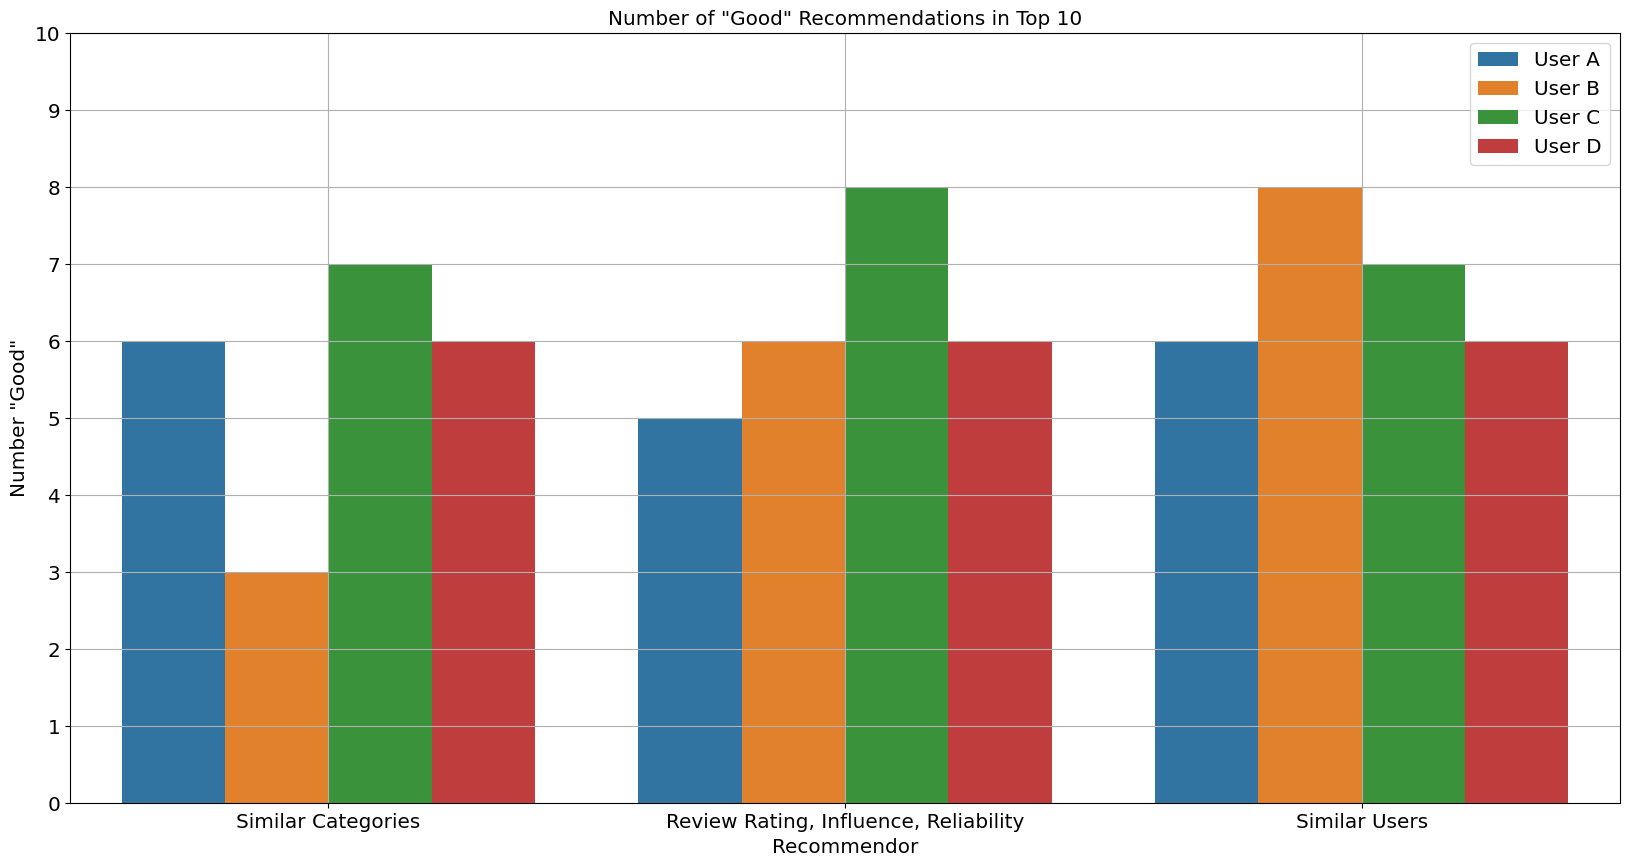

In [50]:
number_good = {'Recommender': ['Similar Categories'] * 4 + ['Review Rating, Influence, Reliability'] * 4 + ['Similar Users'] * 4,
               'User': ['User A', 'User B', 'User C', 'User D'] * 3,
               'Number Good': [sum(user_a_rec_1['good']), sum(user_b_rec_1['good']), sum(user_c_rec_1['good']), sum(user_d_rec_1['good']),
                               sum(user_a_rec_2['good']), sum(user_b_rec_2['good']), sum(user_c_rec_2['good']), sum(user_d_rec_2['good']),
                               sum(user_a_rec_3['good']), sum(user_b_rec_3['good']), sum(user_c_rec_3['good']), sum(user_d_rec_3['good'])]}
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(number_good, x='Recommender', y='Number Good', hue='User')
plt.yticks(list(range(0, 10 + 1)), fontsize='x-large')
plt.xticks(fontsize='x-large')
ax.grid()
plt.ylabel('Number "Good"', fontsize='x-large')
plt.xlabel('Recommendor', fontsize='x-large')
plt.title('Number of "Good" Recommendations in Top 10', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.savefig('results/number_good.jpg', dpi=500, bbox_inches='tight')
plt.show()

"Good" means makes somewhat sense based on user reviews. Similar categories is a good starting point for User A with barely any purchases. Review rating, influence, and reliability is good for User C with well-defined interest in adventure games. Similar users is good or User B with uncommon interest in aerial combat.